In [1]:
#Import libraries required
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D
from matplotlib import pyplot
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# Downloading data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# Scaling Image Pixel Values, as RGB values range from 0-255
x_train= x_train/255
x_test= x_test/255

In [ ]:
#Convolution autoencoder Model
input = Input((32, 32,3))
inp = Conv2D(16, (3, 3), activation='relu', padding='same')(input)  #Conv2D layer with Relu Activation function
inp = MaxPooling2D((2, 2))(inp)                                     #Max pool layer
inp = Conv2D(8, (3, 3), activation='relu', padding='same')(inp)     #Relu Activation function
inp = MaxPooling2D((2, 2))(inp)                                     #Max pool layer
inp = Conv2D(3, (3, 3), activation='relu', padding='same', name='Encode_Layer')(inp)  #name='Encode_Layer' to take output as input for K-means clustering
flatten = Flatten(name='Flatten_Layer')(inp)                        
dense = Dense(64, activation='softmax', name='Dense_Layer')(flatten) #Dense layer with softmax activation
reshape = Reshape((8,8,1))(dense)
output = Conv2DTranspose(3,(3, 3), strides=2, activation='relu', padding='same')(reshape)  #Transposed convolution layer (sometimes called Deconvolution)
output = BatchNormalization()(output)                              
output = Conv2DTranspose(8,(3, 3), strides=2, activation='relu', padding='same')(output)
output = BatchNormalization()(output)                               #Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(output)
model = Model(input, decoded)
model.summary()                                                     #Printing summary of the model

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
Encode_Layer (Conv2D)        (None, 8, 8, 3)           219       
_________________________________________________________________
Flatten_Layer (Flatten)      (None, 192)              

In [ ]:
optim = tf.keras.optimizers.SGD(learning_rate=0.225, name='SGD')                    #defining optimizer SGD
model.compile(optimizer=optim, loss='binary_crossentropy',metrics=['accuracy'])     #Compiling the model with loss as binary cross entropy
model.fit(x_train, x_train, batch_size=64, epochs =10)                              #Fitting the model with input x train

Epoch 1/10
782/782 [==============================] - 90s 115ms/step - loss: 0.6910 - accuracy: 0.5011
Epoch 2/10
782/782 [==============================] - 89s 113ms/step - loss: 0.6908 - accuracy: 0.4983
Epoch 3/10
782/782 [==============================] - 92s 118ms/step - loss: 0.6908 - accuracy: 0.4982
Epoch 4/10
782/782 [==============================] - 89s 114ms/step - loss: 0.6908 - accuracy: 0.4980
Epoch 5/10
782/782 [==============================] - 88s 113ms/step - loss: 0.6908 - accuracy: 0.4959
Epoch 6/10
782/782 [==============================] - 89s 114ms/step - loss: 0.6908 - accuracy: 0.4936
Epoch 7/10
782/782 [==============================] - 90s 115ms/step - loss: 0.6908 - accuracy: 0.4926
Epoch 8/10
782/782 [==============================] - 90s 116ms/step - loss: 0.6907 - accuracy: 0.4924
Epoch 9/10
782/782 [==============================] - 91s 116ms/step - loss: 0.6907 - accuracy: 0.4924
Epoch 10/10
782/782 [==============================] - 91s 117ms/step - l

In [ ]:
#Creating a model taking output from encode layer for input to K-means clustering
encode_layer = Model(inputs=model.input, outputs=model.get_layer('Encode_Layer').output)
coded_pic=encode_layer.predict(x_train)
coded_picTest=encode_layer.predict(x_test)

In [ ]:
#Defining show_pics function to display generated images
def show_pics(X):
  pyplot.figure(figsize=(20,20))
  for i in range(10):
	  pyplot.subplot(1,10,i+1)
	  pyplot.imshow(X[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

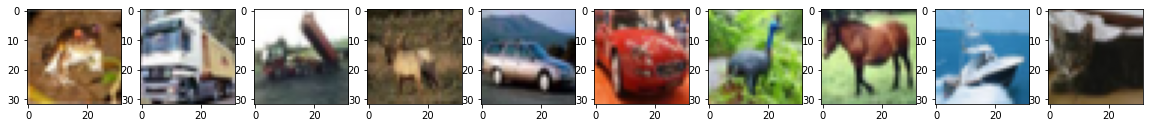

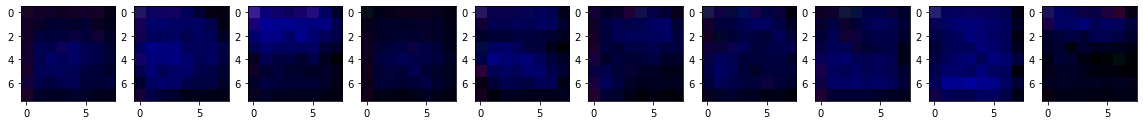

In [ ]:
#Comparing the input and encoded pics
show_pics(x_train)
show_pics(coded_pic)

In [ ]:
# K-means clustering
coded_pic = coded_pic.reshape(x_train.shape[0],-1)
kmeans = KMeans(n_clusters=10,max_iter=200)
kmeans = kmeans.fit(coded_pic)
label_initial=kmeans.labels_
label_final=kmeans.labels_
testLabels=kmeans.predict(coded_picTest.reshape(x_test.shape[0],-1))
testLabelsfinal=kmeans.predict(coded_picTest.reshape(x_test.shape[0],-1))
print("K-means cluster centers:",kmeans.cluster_centers_)

K-means cluster centers: [[ 9.08338577e-02  7.58853406e-02  2.64077246e-01 ... -1.17381660e-11
   1.16226752e-03  1.02313936e-01]
 [ 1.47513151e-01  8.63090158e-02  4.09302175e-01 ... -1.20508048e-11
   1.42254110e-04  1.62623316e-01]
 [ 8.83658379e-02  5.94920777e-02  2.41321325e-01 ...  1.57415116e-06
   3.95922456e-04  8.46029669e-02]
 ...
 [ 8.26356784e-02  6.29051030e-02  2.40234405e-01 ...  1.12413045e-06
   4.06086852e-04  1.65051073e-01]
 [ 1.78017706e-01  9.92649645e-02  4.86362427e-01 ...  5.96855898e-12
   3.89316701e-05  2.00585276e-01]
 [ 1.55955076e-01  9.92046148e-02  4.38936889e-01 ... -1.07434062e-11
   3.63132713e-04  9.01099443e-02]]


In [ ]:
#Printing confusing matrix b/w ytrain,label and ytest,labelTest
matrix= confusion_matrix(y_train,label_initial)
matrixTest= confusion_matrix(y_test, testLabels)
print("Confusion Matrix b/w Ytrain and label\n",matrix,"\n","Confusion Matrix b/w YTest and labelTest\n",matrixTest)
cluster = np.argmax(matrix,axis=0)                #Column wise max values for matrix
clusterTest = np.argmax(matrixTest,axis=0)        #Column wise max values for matrixTest
print("Column wise max values for both the matrices\n",cluster,"\n",clusterTest)

Confusion Matrix b/w Ytrain and label
 [[ 561  817  300  132  170  704  358  372 1144  442]
 [1009  403  605  201  440  528  486  326  388  614]
 [ 289  592 1000  645  516  139  985  239  347  248]
 [ 367  548  634  525  830  131  788  655  285  237]
 [ 251  299 1019  810  953  164  774  340  124  266]
 [ 651  525  640  331  808  138  760  749  220  178]
 [ 270  415 1119 1034  778   30  837  230  164  123]
 [ 498  556  629  269  570  287  816  465  151  759]
 [ 856  474  278   65  217 1323  290  423  312  762]
 [ 485  656  417   67  160  749  547  138  319 1462]] 
 Confusion Matrix b/w YTest and labelTest
 [[124 188  53  16  31 140  71  68 245  64]
 [216 104 111  52  76 106  93  54  76 112]
 [ 56 126 209 119 101  32 190  51  78  38]
 [ 91 109 135  87 176  23 156 111  58  54]
 [ 57  55 211 179 179  19 173  49  21  57]
 [134 102 112  56 148  35 154 166  49  44]
 [ 65  75 212 207 146   8 187  37  40  23]
 [ 90 110 130  36 106  70 148  94  34 182]
 [179  78  34  11  50 287  64  85  52 160]

In [ ]:
#Accuracy using max(column)/total sum i.e without assigning cluster ids to true labels
T=0
for column in matrix:
  T+=np.max(column)
matrixsum= np.sum(matrix)
accuracy= (T/matrixsum)*100
print("Accuracy for training data without assigning cluster ids to true labels is:",accuracy,"%")

Accuracy for training data without assigning cluster ids to true labels is: 21.060000000000002 %


In [ ]:
#Function to replace duplicate with 999
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
        else:
           final_list.append(999)
    return final_list 

In [ ]:
#Function to find missing numbers between 1 to 10
def findMissing(filter):
 list=[1,2,3,4,5,6,7,8,9]
 for i in range(len(list)):
  if filter[i] in list:
    list.remove(filter[i])
 return list

In [ ]:
 #Function to transform 999(duplicates) to missing numbers found
 def transformation(filter,list):
  j=0
  for i in range(len(filter)):
    if filter[i] == 999:
        filter[i] = list[j]
        j=j+1
  return filter

In [ ]:
#Assigning cluster ids to true labels
for i in range(label_initial.shape[0]):
  if(label_initial[i]==0):
    label_initial[i]= cluster[0]
  elif(label_initial[i]==1):
    label_initial[i]= cluster[1]
  elif(label_initial[i]==2):
    label_initial[i]= cluster[2]
  elif(label_initial[i]==3):
    label_initial[i]= cluster[3]
  elif(label_initial[i]==4):
    label_initial[i]= cluster[4]
  elif(label_initial[i]==5):
    label_initial[i]= cluster[5]
  elif(label_initial[i]==6):
    label_initial[i]= cluster[6]
  elif(label_initial[i]==7):
    label_initial[i]= cluster[7]
  elif(label_initial[i]==8):
    label_initial[i]= cluster[8]
  elif(label_initial[i]==9):
    label_initial[i]= cluster[9]

In [ ]:
#Accuracy for Training data
accuracy_score1=accuracy_score(y_train, label_initial)*100
print("Accuracy for training data after assigning cluster ids to true labels is:",accuracy_score1,"%")

Accuracy for training data after assigning cluster ids to true labels is: 21.19 %


In [ ]:
#Calling functions defined to remove cluster ids having same y_train and assigning remaining values of y_train randomly to cluster ids.
filter=Remove(cluster)
missing=findMissing(filter)
final=transformation(filter,missing)

#Assigning cluster ids to labels
for i in range(label_final.shape[0]):
  if(label_final[i]==0):
    label_final[i]= final[0]
  elif(label_final[i]==1):
    label_final[i]= final[1]
  elif(label_final[i]==2):
    label_final[i]= final[2]
  elif(label_final[i]==3):
    label_final[i]= final[3]
  elif(label_final[i]==4):
    label_final[i]= final[4]
  elif(label_final[i]==5):
    label_final[i]= final[5]
  elif(label_final[i]==6):
    label_final[i]= final[6]
  elif(label_final[i]==7):
    label_final[i]= final[7]
  elif(label_final[i]==8):
    label_final[i]= final[8]
  elif(label_final[i]==9):
    label_final[i]= final[9]

In [ ]:
#Accuracy for Training data
accuracy_score2=accuracy_score(y_train, label_final)*100
print("Accuracy for training data after replacing duplicate cluster ids having same Y train is:",accuracy_score2,"%")

Accuracy for training data after replacing duplicate cluster ids having same Y train is: 13.918 %


In [ ]:
#Test Data: Assigning cluster ids to true labels
for i in range(testLabels.shape[0]):
  if(testLabels[i]==0):
    testLabels[i]= clusterTest[0]
  elif(testLabels[i]==1):
    testLabels[i]= clusterTest[1]
  elif(testLabels[i]==2):
    testLabels[i]= clusterTest[2]
  elif(testLabels[i]==3):
    testLabels[i]= clusterTest[3]
  elif(testLabels[i]==4):
    testLabels[i]= clusterTest[4]
  elif(testLabels[i]==5):
    testLabels[i]= clusterTest[5]
  elif(testLabels[i]==6):
    testLabels[i]= clusterTest[6]
  elif(testLabels[i]==7):
    testLabels[i]= clusterTest[7]
  elif(testLabels[i]==8):
    testLabels[i]= clusterTest[8]
  elif(testLabels[i]==9):
    testLabels[i]= clusterTest[9]
accuracy_scoreTest=accuracy_score(y_test, testLabels)*100
print("Accuracy for testing data after assigning cluster ids to true labels is:",accuracy_scoreTest,"%")

Accuracy for testing data after assigning cluster ids to true labels is: 21.65 %


In [ ]:
#Test Data: Removing cluster ids having same y_train and assigning remaining cluster ids.
filter=Remove(clusterTest)
missing=findMissing(filter)
finalTest=transformation(filter,missing)
for i in range(testLabelsfinal.shape[0]):
  if(testLabelsfinal[i]==0):
    testLabelsfinal[i]= finalTest[0]
  elif(testLabelsfinal[i]==1):
    testLabelsfinal[i]= finalTest[1]
  elif(testLabelsfinal[i]==2):
    testLabelsfinal[i]= finalTest[2]
  elif(testLabelsfinal[i]==3):
    testLabelsfinal[i]= finalTest[3]
  elif(testLabelsfinal[i]==4):
    testLabelsfinal[i]= finalTest[4]
  elif(testLabelsfinal[i]==5):
    testLabelsfinal[i]= finalTest[5]
  elif(testLabelsfinal[i]==6):
    testLabelsfinal[i]= finalTest[6]
  elif(testLabelsfinal[i]==7):
    testLabelsfinal[i]= finalTest[7]
  elif(testLabelsfinal[i]==8):
    testLabelsfinal[i]= finalTest[8]
  elif(testLabelsfinal[i]==9):
    testLabelsfinal[i]= finalTest[9]
accuracy_scoreTestFinal=accuracy_score(y_test, testLabelsfinal)*100
print("Accuracy for testing data after replacing duplicate cluster ids having same Y train is:",accuracy_scoreTestFinal,"%")

Accuracy for testing data after replacing duplicate cluster ids having same Y train is: 18.34 %


In [ ]:
#Final accuracies after taking maximum values of accuracy score calculated
final_accuracy_train=max(accuracy_score1,accuracy_score2)
final_accuracy_test=max(accuracy_scoreTest,accuracy_scoreTestFinal)
print("Accuracy for training dataset is:",final_accuracy_train,"%")
print("Accuracy for testing dataset is:",final_accuracy_test,"%")


Accuracy for training dataset is: 21.19 %
Accuracy for testing dataset is: 21.65 %


In [ ]:
#Confusion matrix for testing dataset
print("Confusion Matrix for Testing Dataset is:\n",confusion_matrix(y_test, testLabels))

Confusion Matrix for Testing Dataset is:
 [[433 124  71   0  31  68  69   0 140  64]
 [180 216  93   0  76  54 163   0 106 112]
 [204  56 190   0 101  51 328   0  32  38]
 [167  91 156   0 176 111 222   0  23  54]
 [ 76  57 173   0 179  49 390   0  19  57]
 [151 134 154   0 148 166 168   0  35  44]
 [115  65 187   0 146  37 419   0   8  23]
 [144  90 148   0 106  94 166   0  70 182]
 [130 179  64   0  50  85  45   0 287 160]
 [199  89 118   0  34  29  93   0 163 275]]
